<a href="https://colab.research.google.com/github/tamaghnakundu/learn-pytorch-ml/blob/main/01_PyTorch_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn  # nn contains
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.9.0+cu126'

In [2]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X+bias    # Linear Regression

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

In [4]:
# Create a train/test split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data=X_test,
                     test_labels = y_test,
                     predictions=None):

  plt.figure(figsize=(10,7))

  # PLot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")

  # PLot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test Data")

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size":14})

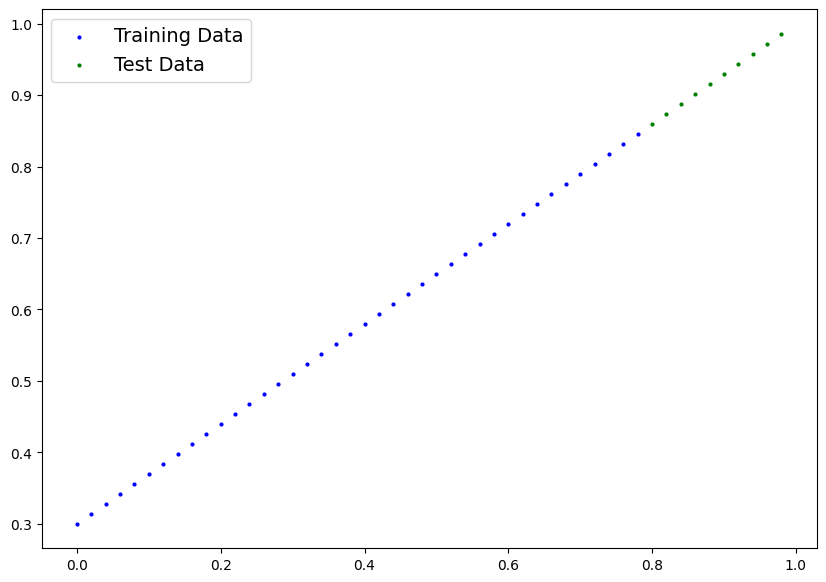

In [6]:
plot_predictions()

In [7]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):   # <- almost everything in PyTorch inherits from NN Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float32
    self.bias = nn.Parameter(torch.randn(1, # start with a random bias and try to adjust it to the ideal bias
                                         requires_grad=True,
                                         dtype=torch.float))
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:  # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula


In [8]:
# Create a random seed
torch.manual_seed(42)

# Create a instance of the model ( this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

#Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`.config
When we pass data through our model, it's going to run it through the `forward()` method.

In [10]:
X_test,y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [11]:
# make predictions with model

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

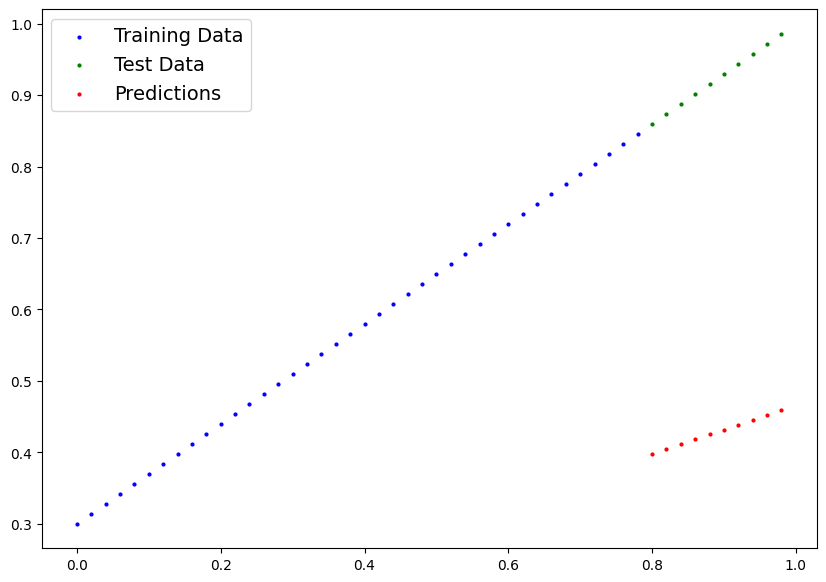

In [12]:
plot_predictions(predictions=y_preds)

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup a optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01)  # lr = learning rate = possibly the most important hyperparameter you can set


In [16]:
torch.manual_seed(42)

# An epoch is one loop through the data...(this is a hyperparameter beacuse we've set them)
epochs = 100

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train()  # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f"Loss: {loss}")

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer(perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acumlate through the loop so... we have to zero them above in step 3 of the iteration

  #testing
  model_0.eval()  # turns off different settings in the model not needed for evalaution/testing
  with torch.inference_mode():  # turns off gradient tracking
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

    if epoch % 10:
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

  # Print out model state_dict()
  print(model_0.state_dict())

Loss: 0.31288138031959534
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Loss: 0.3013603389263153
Epoch: 1 | Loss: 0.3013603389263153 | Test loss: 0.4675942063331604
OrderedDict({'weights': tensor([0.3445]), 'bias': tensor([0.1488])})
Loss: 0.28983935713768005
Epoch: 2 | Loss: 0.28983935713768005 | Test loss: 0.4541231691837311
OrderedDict({'weights': tensor([0.3484]), 'bias': tensor([0.1588])})
Loss: 0.2783183455467224
Epoch: 3 | Loss: 0.2783183455467224 | Test loss: 0.44065219163894653
OrderedDict({'weights': tensor([0.3523]), 'bias': tensor([0.1688])})
Loss: 0.26679736375808716
Epoch: 4 | Loss: 0.26679736375808716 | Test loss: 0.4271811842918396
OrderedDict({'weights': tensor([0.3562]), 'bias': tensor([0.1788])})
Loss: 0.2552763521671295
Epoch: 5 | Loss: 0.2552763521671295 | Test loss: 0.41371020674705505
OrderedDict({'weights': tensor([0.3601]), 'bias': tensor([0.1888])})
Loss: 0.24375534057617188
Epoch: 6 | Loss: 0.24375534057617188 | Test loss: 0.40023916959

In [17]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [18]:
weight, bias

(0.7, 0.3)

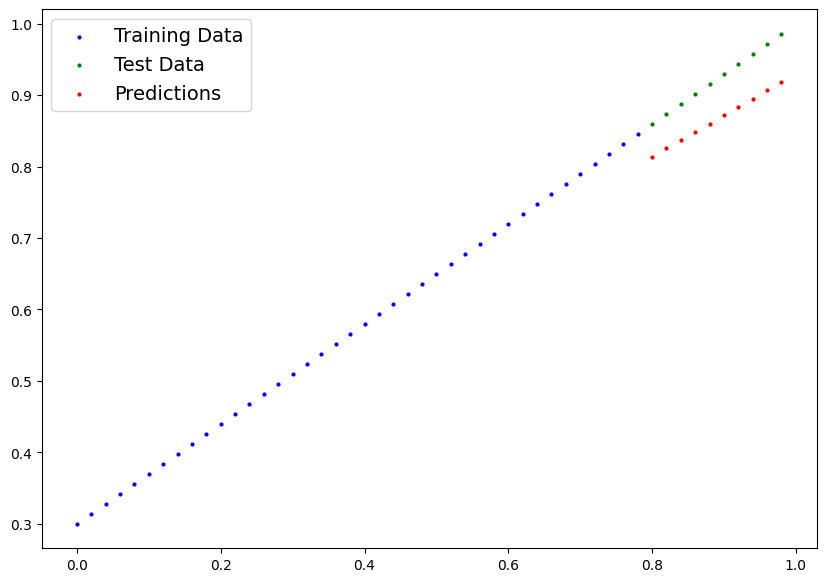

In [19]:
plot_predictions(predictions = y_preds_new)

In [20]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.5784]), 'bias': tensor([0.3513])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [21]:
model_0.eval()

with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [22]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_workflow_model_0.pth


In [23]:
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 2117 Dec 15 19:46 models/01_pytorch_workflow_model_0.pth


In [24]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [25]:
loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds==y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [26]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

In [27]:
device ="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [28]:
weight = 0.7
bias = 0.3
start=0
end=1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y=weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [29]:
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

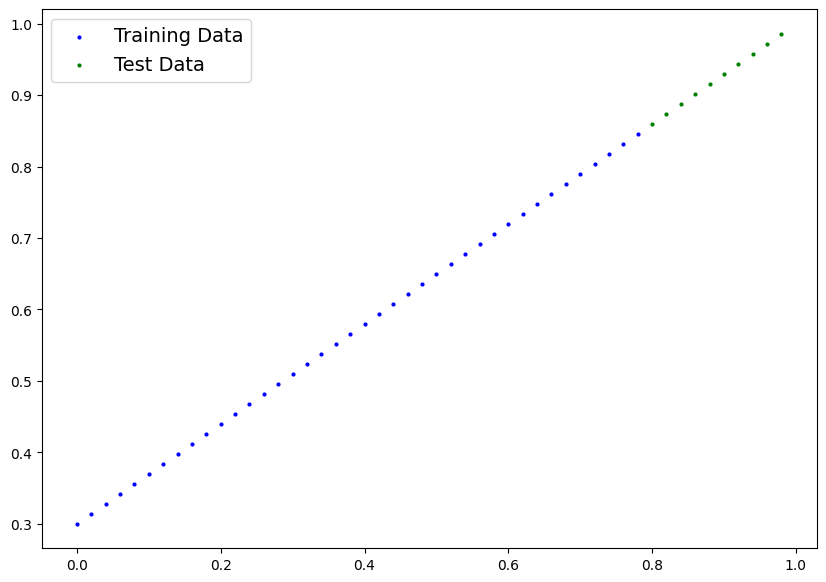

In [30]:
plot_predictions(X_train, y_train, X_test, y_test)

In [31]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [32]:
next(model_1.parameters()).device

device(type='cpu')

In [33]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [34]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

In [35]:
torch.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_pred = model_1(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)
  if epoch%100==0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [36]:
from pprint import pprint
print("The model learned the foolowing valuess for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bais are:")
print(f"Weights: {weight}, bias: {bias}")

The model learned the foolowing valuess for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bais are:
Weights: 0.7, bias: 0.3


In [37]:
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

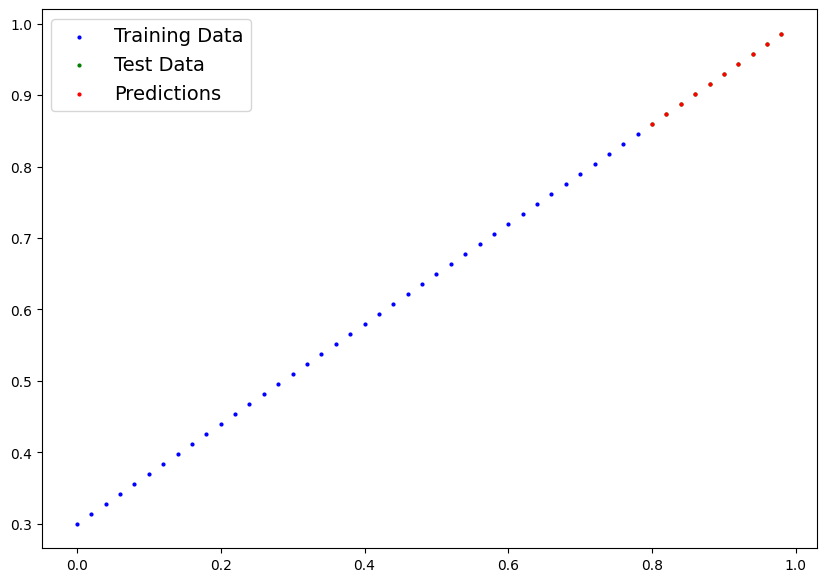

In [38]:
plot_predictions(predictions = y_preds.cpu())

In [39]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [40]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)
print(f"Loaded model: \n{loaded_model_1}")
print(f"Model on device: \n{next(loaded_model_1.parameters()).device}")

Loaded model: 
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device: 
cuda:0


In [41]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

**Exercises**

In [42]:
#1
weight = 0.3
bias = 0.9

X = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y = weight*X+bias
len(X), len(y)

(100, 100)

In [43]:
train_split = int(len(X) * 0.8)
X_train , y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

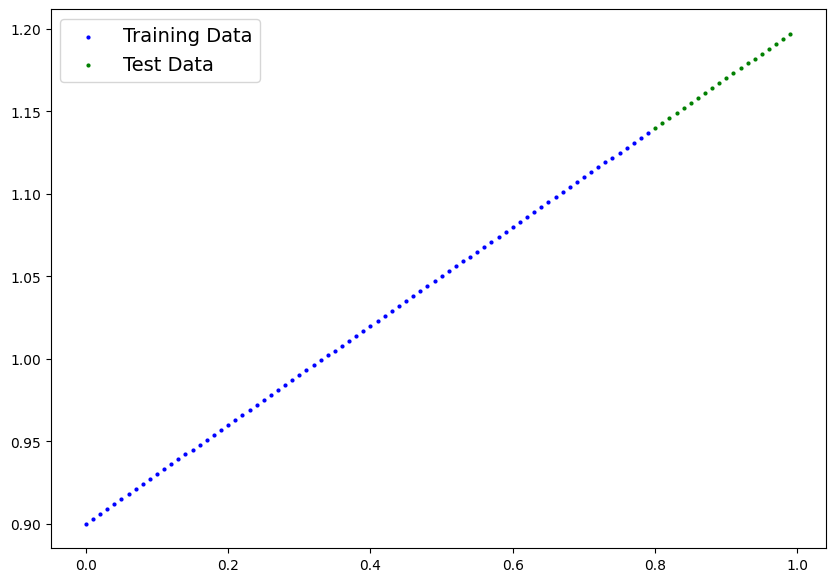

In [44]:
def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None):
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c = "b", s = 4, label = "Training Data")
  plt.scatter(test_data, test_labels, c = "g", s = 4, label = "Test Data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c = "r", s = 4, label = "Predictions")
  plt.legend(prop = {"size":14})
plot_predictions()

In [45]:
class LinearRegressionModelV3(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_2 = LinearRegressionModelV3()
model_2, model_2.state_dict()

(LinearRegressionModelV3(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [46]:
next(model_2.parameters()).device

device(type='cpu')

In [47]:
model_2.to(device)
list(model_2.parameters())

[Parameter containing:
 tensor([[0.7645]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.8300], device='cuda:0', requires_grad=True)]

In [48]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.01)

In [49]:
torch.manual_seed(42)
epochs = 300

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()

  with torch.inference_mode():
    y_preds = model_2(X_test)
    test_loss = loss_fn(y_preds,y_test)

  if epoch%20==0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.1275613158941269 | Test loss: 0.33650314807891846
Epoch: 20 | Train loss: 0.08187223970890045 | Test loss: 0.21840262413024902
Epoch: 40 | Train loss: 0.07207288593053818 | Test loss: 0.17458660900592804
Epoch: 60 | Train loss: 0.06507988274097443 | Test loss: 0.15310420095920563
Epoch: 80 | Train loss: 0.05822876840829849 | Test loss: 0.1367770880460739
Epoch: 100 | Train loss: 0.05137667804956436 | Test loss: 0.12079393863677979
Epoch: 120 | Train loss: 0.04452557489275932 | Test loss: 0.10446684807538986
Epoch: 140 | Train loss: 0.0376744270324707 | Test loss: 0.08813951909542084
Epoch: 160 | Train loss: 0.03082224726676941 | Test loss: 0.0721558928489685
Epoch: 180 | Train loss: 0.02397105097770691 | Test loss: 0.055828340351581573
Epoch: 200 | Train loss: 0.017119847238063812 | Test loss: 0.03950077295303345
Epoch: 220 | Train loss: 0.010267681442201138 | Test loss: 0.02351718582212925
Epoch: 240 | Train loss: 0.003416901919990778 | Test loss: 0.0071918368

In [50]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test)
y_preds

tensor([[1.1333],
        [1.1363],
        [1.1393],
        [1.1423],
        [1.1454],
        [1.1484],
        [1.1514],
        [1.1545],
        [1.1575],
        [1.1605],
        [1.1635],
        [1.1666],
        [1.1696],
        [1.1726],
        [1.1757],
        [1.1787],
        [1.1817],
        [1.1847],
        [1.1878],
        [1.1908]], device='cuda:0')

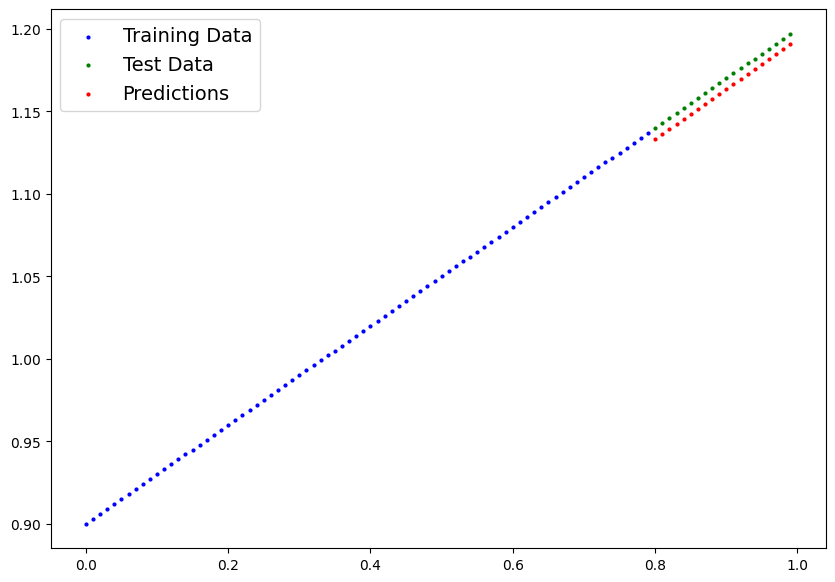

In [51]:
plot_predictions(predictions= y_preds.to("cpu"))

In [52]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok = True)

MODEL_NAME = "01_pytorch_model"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_model


In [53]:
loaded_model = LinearRegressionModelV3()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)

LinearRegressionModelV3(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [54]:
y_preds_new = loaded_model(X_test)
y_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')